In [106]:
#Importation de la base de donées 
import pandas as pd

# Charger un fichier SAS (.sas7bdat)
df = pd.read_sas("../data/raw/credit.sas7bdat", format="sas7bdat", encoding="latin1")

# Afficher les premières lignes
print(df.head())

   Cle  Comptes  Duree_credit Historique_credit Objet_credit  Montant_credit  \
0  1.0      1.0           6.0               A34          A43          1169.0   
1  2.0      2.0          48.0               A32          A43          5951.0   
2  3.0      4.0          12.0               A34          A46          2096.0   
3  4.0      1.0          42.0               A32          A42          7882.0   
4  5.0      1.0          24.0               A33          A40          4870.0   

   Epargne  Anciennete_emploi  Taux_effort Situation_familiale  ...  \
0      0.0                5.0          4.0                 A93  ...   
1      1.0                3.0          2.0                 A92  ...   
2      1.0                4.0          2.0                 A93  ...   
3      1.0                4.0          2.0                 A93  ...   
4      1.0                3.0          3.0                 A93  ...   

  Anciennete_domicile  Biens   Age  Autres_credits Statut_domicile Nb_credits  \
0          

In [107]:
#Recoder la variable Cible en 0 et 1 
df['Cible'] = df['Cible'].map({1: 0, 2: 1})

In [108]:
#Voir la nature des variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cle                  1000 non-null   float64
 1   Comptes              1000 non-null   float64
 2   Duree_credit         1000 non-null   float64
 3   Historique_credit    1000 non-null   object 
 4   Objet_credit         1000 non-null   object 
 5   Montant_credit       1000 non-null   float64
 6   Epargne              1000 non-null   float64
 7   Anciennete_emploi    1000 non-null   float64
 8   Taux_effort          1000 non-null   float64
 9   Situation_familiale  1000 non-null   object 
 10  Garanties            1000 non-null   object 
 11  Anciennete_domicile  1000 non-null   float64
 12  Biens                1000 non-null   object 
 13  Age                  1000 non-null   float64
 14  Autres_credits       1000 non-null   object 
 15  Statut_domicile      1000 non-null   ob

In [109]:
#Analyse des valeurs manquantes
df.isnull().sum() #pas de valeurs manquantes

Cle                    0
Comptes                0
Duree_credit           0
Historique_credit      0
Objet_credit           0
Montant_credit         0
Epargne                0
Anciennete_emploi      0
Taux_effort            0
Situation_familiale    0
Garanties              0
Anciennete_domicile    0
Biens                  0
Age                    0
Autres_credits         0
Statut_domicile        0
Nb_credits             0
Type_emploi            0
Nb_pers_charge         0
Telephone              0
Cible                  0
dtype: int64

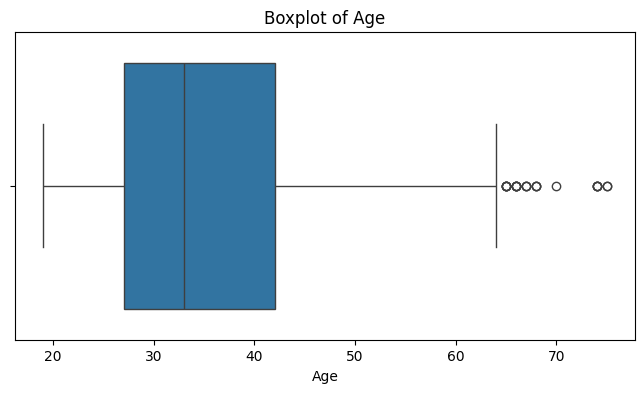

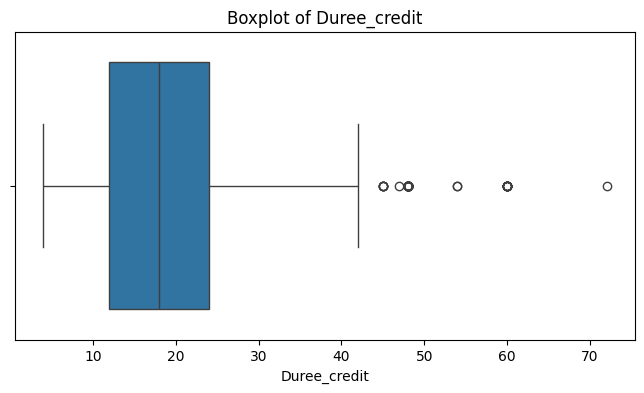

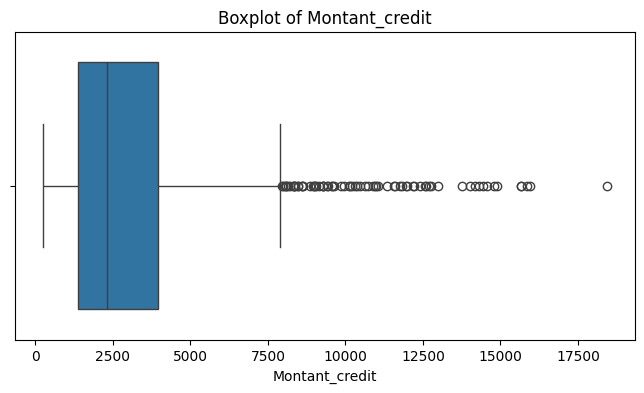

In [110]:
#Analyse des outliers

numeric_cols = ['Age', 'Duree_credit', 'Montant_credit']

import matplotlib.pyplot as plt
import seaborn as sns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [111]:
# Vérifier la présence d'outliers sur les variables

# Duree_credit
from scikit_posthocs import outliers_gesd
no_outlier = outliers_gesd(df["Duree_credit"], alpha=0.05, hypo=False)
len(no_outlier) # 1 outliers
df = df[df["Duree_credit"] != df["Duree_credit"].max()]

In [112]:
# Montant_credit
no_outlier = outliers_gesd(df["Montant_credit"], alpha=0.05, hypo=False)
len(no_outlier) # 5 outliers
df = df.drop(df.nlargest(5, "Montant_credit").index)


In [113]:
#Age
no_outlier = outliers_gesd(df["Age"], alpha=0.05, hypo=False)
len(no_outlier) # pas outliers

994

On a enlevé 6 observations atypiques sur l'ensemble de nos variables quantitatives

In [97]:
df.shape

(994, 21)

In [59]:
%store df

Stored 'df' (DataFrame)


In [114]:
#Matrice corrélation
#Sous ensemble des variables num
numeric_cols = ['Age', 'Duree_credit', 'Montant_credit']
corr = df[numeric_cols].corr()
print(corr) #Il faudra créer une variable (variable croisée) pour regrouper Duree_credit  et Montant_credit  corrélation >0.40

                     Age  Duree_credit  Montant_credit
Age             1.000000     -0.031622        0.036083
Duree_credit   -0.031622      1.000000        0.615537
Montant_credit  0.036083      0.615537        1.000000


In [115]:
#Création de la variable Credit_ratio
df['Credit_ratio'] = df['Montant_credit'] / df['Duree_credit']

In [116]:
#Séparer notre jeu train et test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Cible'])
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (795, 22), Test shape: (199, 22)


In [117]:
#Cost classing de nos variables quantitatives sur le jeu train
from sklearn.preprocessing import KBinsDiscretizer
numeric_cols2 = ['Age', 'Credit_ratio']
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
train_df[numeric_cols2] = kbins.fit_transform(train_df[numeric_cols2])
print(train_df[numeric_cols2].head())

     Age  Credit_ratio
719  2.0           4.0
19   2.0           2.0
999  1.0           1.0
446  2.0           0.0
928  4.0           0.0


c:\Users\Timothée\Documents\M2 ECAP\Modélisation du risque de crédit et scoring\projet_scoring\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [118]:
import numpy as np

def psi(expected, actual):
    """Calcul PSI entre deux distributions"""
    expected = np.array(expected)
    actual = np.array(actual)
    # éviter division par zéro
    expected = np.where(expected == 0, 0.0001, expected)
    actual = np.where(actual == 0, 0.0001, actual)
    return np.sum((expected - actual) * np.log(expected / actual))


In [119]:
# Fraction 50/50 pour simuler "ancienne" et "nouvelle" population
train_old = train_df.sample(frac=0.5, random_state=42)
train_new = train_df.drop(train_old.index)


In [120]:
for col in numeric_cols2:
    dist_old = train_old[col].value_counts(normalize=True).sort_index()
    dist_new = train_new[col].value_counts(normalize=True).sort_index()
    psi_val = psi(dist_old, dist_new)
    
    # Interprétation
    if psi_val < 0.1:
        status = "stable"
    elif psi_val < 0.25:
        status = "modérément instable"
    else:
        status = "instable"
    
    print(f"{col} PSI = {psi_val:.4f} → {status}")

Age PSI = 0.0475 → stable
Credit_ratio PSI = 0.0250 → stable
